# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import numpy as np
import time
import pickle
import torch

from unityagents import UnityEnvironment
from collections import deque
from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='unity/Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [4]:
def save(param, agent, score_list, avg_score_list, i_episode, current_score):
    BATCH_SIZE = param["BATCH_SIZE"]
    LEARNING_REPEAT = param["LEARNING_REPEAT"]
    LR_ACTOR = param["LR_ACTOR"] / 1e-4
    LR_CRITIC = param["LR_CRITIC"] / 1e-4
    info_str = '_{}_{}_{:.0f}_{:.0f}_{}_{:.0f}'.format(BATCH_SIZE,LEARNING_REPEAT,LR_ACTOR,LR_CRITIC,i_episode, current_score)
    with open('score_log/score'+info_str+'.pk', 'wb') as f:
        pickle.dump(score_list, f)
    with open('score_log/avg_score'+info_str+'.pk', 'wb') as f:
        pickle.dump(avg_score_list, f)
    torch.save(agent.actor_local.state_dict(), 'pytorch_weight/checkpoint_actor'+info_str+'.pt')
    torch.save(agent.critic_local.state_dict(), 'pytorch_weight/checkpoint_critic'+info_str+'.pt')

In [5]:
def ddpg(env, env_info, agent, num_agents, param, n_episodes=250, max_t=700):  
    scores_deque = deque(maxlen=100)
    score_list = []
    avg_score_list = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        starting_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if np.any(dones):                                  # exit loop if episode finished
                break

        proc_time = (time.time()-starting_time)/60

        score = np.mean(scores)
        scores_deque.append(score)
        score_list.append(score)
        avg_score_list.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f} proc_time {:.2f}m'.format(i_episode, np.mean(scores_deque),proc_time), end="")
        if(i_episode % 10 == 0):
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if(np.mean(scores_deque) >= 30):
            print('\rProblem is solved at Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        elif(i_episode > 100 and np.mean(scores_deque) < 5):
            break
    save(param, agent, score_list, avg_score_list, i_episode, np.mean(scores_deque))
    return score_list, avg_score_list

### 3. Train the Agent with DDPG

In [6]:
LR = 1e-4
param = {
    "BUFFER_SIZE" : int(1e6),  # replay buffer size
    "BATCH_SIZE" : 128,        # minibatch size
    "GAMMA" : 0.99,            # discount factor
    "TAU" : 1e-3,              # for soft update of target parameters
    "LR_ACTOR" : LR,         # learning rate of the actor 
    "LR_CRITIC" : LR,        # learning rate of the critic
    "WEIGHT_DECAY" : 0.0000,   # L2 weight decay
    "LEARNING_REPEAT" : 20,     # updating the actor and critic networks LEARNING_REPEAT times
    "LEARNING_STEP" : 20        # at every LEARNING_STEP
}

In [8]:
for BATCH_SIZE in [128, 256, 512]:
    for LEARNING_REPEAT in [5, 10, 20]:
        for i in range(-1,2):
            param["BATCH_SIZE"] = BATCH_SIZE
            param["LEARNING_REPEAT"] = LEARNING_REPEAT
            param["LR_ACTOR"] = LR*(10**i)
            param["LR_CRITIC"] = LR*(10**i)
            agent = Agent(state_size, action_size, num_agents, param, 10)
            ddpg(env, env_info, agent, num_agents, param)
            del agent

Episode 10	Average Score: 0.13 proc_time 0.09m
Episode 20	Average Score: 0.15 proc_time 0.09m
Episode 30	Average Score: 0.33 proc_time 0.09m
Episode 40	Average Score: 0.43 proc_time 0.10m
Episode 50	Average Score: 0.51 proc_time 0.10m
Episode 60	Average Score: 0.58 proc_time 0.10m
Episode 70	Average Score: 0.63 proc_time 0.11m
Episode 80	Average Score: 0.66 proc_time 0.10m
Episode 90	Average Score: 0.70 proc_time 0.10m
Episode 100	Average Score: 0.73 proc_time 0.11m
Episode 10	Average Score: 0.50 proc_time 0.08mm
Episode 20	Average Score: 0.82 proc_time 0.08m
Episode 30	Average Score: 0.92 proc_time 0.09m
Episode 40	Average Score: 0.86 proc_time 0.10m
Episode 50	Average Score: 0.88 proc_time 0.10m
Episode 60	Average Score: 0.95 proc_time 0.10m
Episode 70	Average Score: 1.00 proc_time 0.10m
Episode 80	Average Score: 1.00 proc_time 0.11m
Episode 90	Average Score: 0.99 proc_time 0.10m
Episode 100	Average Score: 0.97 proc_time 0.11m
Episode 10	Average Score: 0.77 proc_time 0.08mm
Episode 2

Episode 100	Average Score: 8.20 proc_time 0.50m
Episode 110	Average Score: 10.15 proc_time 0.53m
Episode 120	Average Score: 12.28 proc_time 0.51m
Episode 130	Average Score: 14.38 proc_time 0.51m
Episode 140	Average Score: 16.83 proc_time 0.52m
Episode 150	Average Score: 19.40 proc_time 0.53m
Episode 160	Average Score: 22.05 proc_time 0.54m
Episode 170	Average Score: 24.48 proc_time 0.52m
Episode 180	Average Score: 26.81 proc_time 0.51m
Episode 190	Average Score: 29.35 proc_time 0.56m
Problem is solved at Episode 194	Average Score: 30.19


### 4. find the best parameters

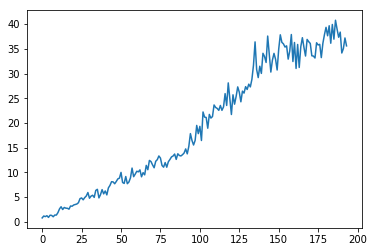

In [28]:
import matplotlib.pyplot as plt

with open('score_log/score_512_20_10_10_194_30.pk', 'rb') as f:
    score = pickle.load(f)
plt.plot(score)

### 5. Watch a Smart Agent!

In [8]:
param["BATCH_SIZE"] = 512
param["LEARNING_REPEAT"] = 20
param["LR_ACTOR"] = LR*(10**10)
param["LR_CRITIC"] = LR*(10**10)
agent = Agent(state_size, action_size, num_agents, param, 10)

agent.actor_local.load_state_dict(torch.load('pytorch_weight/checkpoint_actor_512_20_10_10_194_30.pt'))
agent.critic_local.load_state_dict(torch.load('pytorch_weight/checkpoint_critic_512_20_10_10_194_30.pt'))

In [10]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

In [11]:
env.close()